In [1]:
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import bathyutils

First we set the extent of our map in degrees

In [3]:
S_lim = 57
N_lim = 59
W_lim = 17
E_lim = 23

Next we subset bathymetric data from either [emodnet](https://portal.emodnet-bathymetry.eu/) (hi-res, Europe only) or [GEBCO ](https://download.gebco.net/)(global). To subset the data, we can use the functions `bathyutils.gebco_subset` or `bathyutils.emod_subset`. Both functions require the path to the bathymetry datasets, and the extent of the area to be mapped

In [4]:
bathyutils.emod_subset?

Signature: bathyutils.emod_subset(extent, path_to_emodnet, buffer=0.2)
Docstring:
Selects the EMODnet bathymetry tiles that cover the user defined area and
combines them for a seamless bathymetry. Returns lon, lat and bathy.
:param extent: list with four items which are extent of desired geotiff [South, North, West, East]
e.g. [49. 50.5, -5, 2] (if using gebco or emodnet)
:param path_to_emodnet: string or path to the folder containing EMODnet .nc files, specified by user
:param buffer: size in degrees of extra area around specified coordinates to return. Detaults to 0.2.
:return: xarray object of subset bathymetry
File:      ~/Documents/data-flow/bathy_maps/bathyutils.py
Type:      function


In [5]:
emodnet_path = "/home/callum/Documents/datasets/bathy/emodnet"
extent = (S_lim, N_lim, W_lim, E_lim)
ds_bathy = bathyutils.emod_subset(extent, emodnet_path)

Found tiles [PosixPath('/home/callum/Documents/datasets/bathy/emodnet/C6_2020.nc'), PosixPath('/home/callum/Documents/datasets/bathy/emodnet/D7_2020.nc'), PosixPath('/home/callum/Documents/datasets/bathy/emodnet/C7_2020.nc'), PosixPath('/home/callum/Documents/datasets/bathy/emodnet/C5_2020.nc'), PosixPath('/home/callum/Documents/datasets/bathy/emodnet/D5_2020.nc'), PosixPath('/home/callum/Documents/datasets/bathy/emodnet/D6_2020.nc')]
Found 1 tiles with relevant data: [PosixPath('/home/callum/Documents/datasets/bathy/emodnet/D6_2020.nc')]


**NB** EMODnet bathymetry data is very hi-res. To speed up plotting, I recommend subsetting it during development, then plotting it at original resolution by setting stride to 1 when you are happy with your map 

In [6]:
stride = 100
lon = ds_bathy.lon[::stride]
lat = ds_bathy.lat[::stride]
bathy = ds_bathy.elevation[::stride, ::stride].values
# set all land to 0 m, we only want bathymetry
bathy[bathy>0] = 0

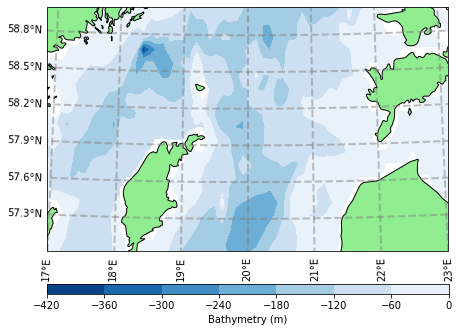

In [7]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)

bathy_c = ax.contourf(lon, lat, bathy, transform=pc, cmap="Blues_r")
ax.set_extent((W_lim, E_lim, S_lim, N_lim), crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                       scale='10m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None
fig.colorbar(bathy_c,ax=ax,orientation='horizontal',label='Bathymetry (m)',shrink=0.6,pad=0.1,aspect=40);


# Big map

EMODnet is great for hi-res maps of European seas, but the high resolution can exceed a computer's RAM when we want to map larger extents. Instead we use GEBCO

In [8]:
S_lim = 45
N_lim = 65
W_lim = -20
E_lim = 25

In [9]:
gebco_path = "/home/callum/Documents/datasets/bathy/gebco_2022_sub_ice_topo/GEBCO_2022_sub_ice_topo.nc"
extent = (S_lim, N_lim, W_lim, E_lim)
ds_gebco = bathyutils.gebco_subset(gebco_path, extent, buffer=15) # big buffer value as we're going far north

Loading GEBCO data...
Subsetting GEBCO data


In [10]:
stride = 100
lon = ds_gebco.lon[::stride]
lat = ds_gebco.lat[::stride]
bathy = ds_gebco.elevation[::stride, ::stride].values

bathy[bathy>0] = 0

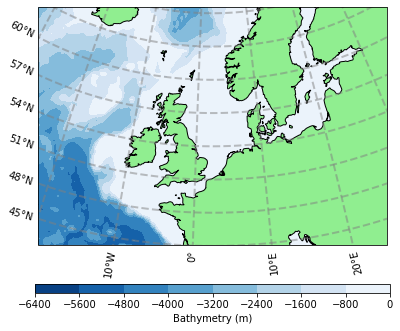

In [14]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)

bathy_c = ax.contourf(lon, lat, bathy, transform=pc, cmap="Blues_r")
ax.set_extent((W_lim, E_lim, S_lim, N_lim), crs=pc)

# Note that here we use the lower def land at 50m scale rather than 10m so the coastlines don't get too messy
feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                       scale='50m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None
fig.colorbar(bathy_c,ax=ax,orientation='horizontal',label='Bathymetry (m)',shrink=0.53,pad=0.12,aspect=40);